In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd


df = pd.read_parquet('/content/drive/MyDrive/techlabs_Daten/datatechlabs_2020_clean.parquet')

Wir arbeiten hier nur mit den Daten von 2022 und 2023

In [ ]:
df = df[df['Datum'].str.contains('2022|2023')]

Reden mit weniger als 1000 Zeichen ausschließen

In [ ]:
df = df[df['Rede'].str.len() >= 1000]

Spalten in "Input" und "label" umbenennen für Huggingface transformers

In [ ]:
df = df.rename(columns={'Fraktion':'labels'})

Transformers erwartet, dass "label" integer enthält... die Fraktionen werden also in int umkodiert

In [ ]:
fraktionen = df['labels'].unique()
mapping = {fraktion: i for i, fraktion in enumerate(fraktionen)}
df['labels'] = df['labels'].map(mapping)
print(mapping)

{'FDP': 0, 'CDU/CSU': 1, 'SPD': 2, 'AfD': 3, 'Die Grünen': 4, 'Die Linke': 5}


Da das Modell "GBert" nur 512 tokens, also ca. 3000 Zeichen auf einmal verarbeiten kann (s. unten), wird hier eine Funktion implementiert, mit der alle Reden, die länger sind als 3000 Zeichen in der Hälfte zerschnitten werden... dieser Vorgang wird solange wiederholt, bis alle Beobachtungen maximal 3000 Zeichen lang sind.

In [ ]:
import math

def cutter(df, max_zeichen):
  df = df.reset_index(drop = True)
  if df['Rede'].str.len().max() <= max_zeichen:
    return df
  else:
    seclist = []
    for i in range(len(df)):
      if len(df.loc[i]['Rede']) > max_zeichen:
        splitpoint = math.ceil(len(df.iloc[i]['Rede']) / 2)
        firstpart = df.loc[i].copy()
        secpart = df.loc[i].copy()
        firstpart['Rede'] = firstpart['Rede'][:splitpoint]
        secpart['Rede'] = secpart['Rede'][splitpoint:]
        df.loc[i] = firstpart
        seclist.append(secpart)

    df2 = pd.DataFrame(seclist)
    df2.index = df2.index + 0.5
    df = pd.concat([df, df2]).sort_index()

    print('Der längste Schnipsel hat jetzt nur noch',df['Rede'].str.len().max(), 'Zeichen')
  df = cutter(df = df, max_zeichen = max_zeichen)
  return df




In [ ]:
df_cut = cutter(df = df, max_zeichen = 3000)

Der längste Schnipsel hat jetzt nur noch 18903 Zeichen
Der längste Schnipsel hat jetzt nur noch 9452 Zeichen
Der längste Schnipsel hat jetzt nur noch 4726 Zeichen
Der längste Schnipsel hat jetzt nur noch 3000 Zeichen


In [ ]:
print(df_cut["labels"].value_counts(), "\n\n\n")
print(mapping)

labels
2    7453
1    6790
4    4584
0    3609
3    3060
5    1864
Name: count, dtype: int64 



{'FDP': 0, 'CDU/CSU': 1, 'SPD': 2, 'AfD': 3, 'Die Grünen': 4, 'Die Linke': 5}


In [ ]:
print(max(df['Rede'].str.len()))

print(max(df_cut['Rede'].str.len()))

67429
3000


In [ ]:
print(min(df['Rede'].str.len()))

print(min(df_cut['Rede'].str.len()))

1000
1000


Aufteilen in test, validation und trainingsset.
Wir suchen uns hier einen kleineren Trainingsdatensatz heraus.

In [ ]:

df_val = df_cut[df_cut['Datum'].str.contains('2023')]
#df_test = df_cut[df_cut['Datum'].str.contains('2024|2025')]

df_training_cut = df_cut[df_cut['Datum'].str.contains('2022')]


df_training_full = df[df['Datum'].str.contains('2022')]

In [ ]:
print(df_training_cut["labels"].value_counts(), "\n\n\n")
print(mapping)

labels
2    3633
1    3406
4    2277
0    1826
3    1552
5     932
Name: count, dtype: int64 



{'FDP': 0, 'CDU/CSU': 1, 'SPD': 2, 'AfD': 3, 'Die Grünen': 4, 'Die Linke': 5}


**ACHTUNG** Die Verteilung der Zeichenlängen über die Parteien sollte dringend noch kontrolliert werden!

In [ ]:
#print(df_training["label"].value_counts(), "\n\n\n")

Optional: ein Dataframe erstellen, indem Unterschiede in den Häufigkeiten (und Längen) der Reden neutralisiert sind, d. h. zufällig so viele Beobachtungen ausgewählt werden (ohne Zurücklegen natürlich), wie die Partei mit den wenigsten Beobachtungen hat

In [ ]:
def sample_per_label(group, n=3750, random_state=42):
    return group.sample(n=n, replace=False, random_state=random_state)


df_train_sampled = df_training.groupby('label', group_keys=False).apply(sample_per_label)

Besser: Daten augmentieren

In [ ]:
import random

def expand(df_training_cut, df_training_complete, max_zeichen = 3000, seed = 42):

  random.seed(seed)

  df_training_filled = df_training_cut


  max_speech = df_training_cut["labels"].value_counts().max()

  for i in range(6):

    num_add = max_speech - (df_training_cut["labels"] == i).sum()

  # aus dem **ursprünglichen** Datensatz df zufällig Reden herauspicken
    added = df_training_complete[df_training_complete["labels"] == i].sample(n = num_add, replace = True, random_state = 42).copy()

    for j in range(len(added)):

      if len(added.iloc[j]["Rede"]) > max_zeichen:

        start = random.choice(range((len(added.iloc[j]["Rede"]) - max_zeichen)))
        ende = start + max_zeichen

        added.loc[added.index[j], "Rede"] = added.iloc[j]["Rede"][start:ende]


    df_training_filled = pd.concat([df_training_filled, added])


  df_training_filled.sort_index()
  df_training_filled.reset_index()

  return df_training_filled

In [ ]:
df_training = expand( df_training_cut = df_training_cut, df_training_complete= df_training_full, max_zeichen = 3000, seed = 42)

In [ ]:
print(df_training["labels"].value_counts(), "\n\n\n")
print(mapping)

labels
0    3633
1    3633
2    3633
3    3633
4    3633
5    3633
Name: count, dtype: int64 



{'FDP': 0, 'CDU/CSU': 1, 'SPD': 2, 'AfD': 3, 'Die Grünen': 4, 'Die Linke': 5}


Ab hier beginnt die Tokenisierung und das eigentliche Training des Modells!!!

Umwandeln der pandas-Dataframes in Datasets, die lediglich noch "label" und "Rede" enthalten

In [ ]:
#! pip install datasets

In [ ]:
from datasets import Dataset

ds_val = Dataset.from_pandas(df_val[['Rede', 'labels']])
#ds_test = Dataset.from_pandas(df_test[['Rede', 'labels']])
ds_training = Dataset.from_pandas(df_training[['Rede', 'labels']])

validation- und test-set in ein Dataset-Dictionary umwandeln

In [ ]:
from datasets import DatasetDict

dds = DatasetDict({
    'train': ds_training,
    'validation': ds_val
})

Ab hier beginnt die **Tokenisierung**



In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

model_checkpoint = 'dbmdz/bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

nachschlagen, wie viele tokens das Modell auf einmal verarbeiten kann

In [ ]:
tokenizer.model_max_length

512

Optional: Anhand eines Beispiels schauen, wie sich die Zeichenanzahl in den Reden in tokens übersetzen... hier ist davon auszugehen, dass 512 tokens ca. 3000 Zeichen sind.

In [ ]:
text = 'Sehr geehrte Frau Präsidentin! Liebe Frau Wehrbeauftragte! Herr Minister Pistorius! Meine Kolleginnen und Kollegen! Wir als SPD-Bundestagsfraktion setzen uns auch in den letzten Wochen dieser Legislaturperiode weiterhin für die Sicherheit unseres Landes ein. Dazu beschließen wir gleich gemeinsam und fraktionsübergreifend mehrere Gesetze, unter anderem auch das Gesetz über die Strafbarkeit der Ausübung von Tätigkeiten für fremde Mächte. Dies ist ein Baustein, um unsere Sicherheit besser zu gewährleisten. Um was geht es dabei? In der Vergangenheit gab es Presseberichte zu möglichen Fällen, in denen ehemalige Mitglieder der Bundeswehr von ausländischen, nicht-alliierten Staaten durch verlockende finanzielle Angebote angeworben wurden. Diese Entwicklungen sind nicht nur besorgniserregend, sie stellen auch eine Bedrohung für unsere nationale Sicherheit dar. Denn bei solchen Tätigkeiten kann eine Weitergabe von militärischem Fachwissen und vertraulichen Informationen nicht ausgeschlossen werden. Dass allein die Möglichkeit von Informations- und Fähigkeitsweitergabe eine Gefahr für uns alle darstellt, dürfte in diesem Hohen Hause eigentlich von niemandem infrage gestellt werden. Deshalb ist es notwendig, dass wir die bestehenden Regelungen anpassen. Der vorliegende Gesetzentwurf sieht vor, dass künftig alle ehemaligen Soldatinnen und Soldaten, die für eine fremde Macht tätig werden wollen, diese Absicht melden müssen und eben auch eine Genehmigung dafür einholen müssen. Eine ungenehmigte Tätigkeit von ehemaligen Zeit- und Berufssoldaten der Bundeswehr für fremde Mächte kann zukünftig mit einer Freiheitsstrafe von bis zu drei Jahren oder mit Geldstrafe geahndet werden. Denn eines dürfen wir alle miteinander nicht vergessen: Sicherheit ist eben nicht nur die Abwehr von Bedrohungen von außen, sie ist auch der Schutz vor der Gefahr, dass sicherheitsrelevante Informationen und militärisches Fachwissen an Staaten weitergegeben werden, die nicht unsere Partner sind, die nicht unsere Werte teilen und die nicht unseren Ansatz von Freiheit und Gerechtigkeit teilen. Denn eines dürfen wir alle miteinander nicht vergessen: Sicherheit ist eben nicht nur die Abwehr von Bedrohungen von außen, sie ist auch der Schutz vor der Gefahr, dass sicherheitsrelevante Informationen und militärisches Fachwissen an Staaten weitergegeben werden, die nicht unsere Partner sind, die nicht unsere Werte teilen und die nicht unseren Ansatz von Freiheit und Gerechtigkeit teilen. Liebe Kolleginnen und Kollegen, wir sind nicht die Einzigen, die solche Gesetze erlassen. Unsere NATO- Partner haben dies getan oder sind gerade dabei, ähnliche Gesetze zu erlassen, um ihre nationalen Geheimnisse und Sicherheitsinteressen zu wahren. Liebe Kolleginnen und Kollegen, die Sicherheit unseres Landes ist unser allerhöchstes Gut, unser aller Interesse. Der vorliegende Gesetzentwurf stärkt nun diesen Schutz und trägt zur Wahrung dieser Interessen bei. Er stellt sicher, dass in Zukunft niemand mehr Informationen, die er oder sie im Dienst der Bundeswehr erhalten hat, an Fremde weitergeben und dadurch unsere Verteidigungsfähigkeit gefährden kann.'


tokens = tokenizer.tokenize(text)

print(f"Anzahl der Zeichen: {len(text)}")
print(f"Anzahl der Tokens: {len(tokens)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors


Anzahl der Zeichen: 3140
Anzahl der Tokens: 558


In [ ]:
def tokenize_function(examples):
  return tokenizer(examples['Rede'], truncation = True)

tokenized_datasets = dds.map(tokenize_function, batched = True)
tokenized_datasets = tokenized_datasets.remove_columns(['Rede', '__index_level_0__'])
tokenized_datasets.set_format('torch')

data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

Map:   0%|          | 0/21798 [00:00<?, ? examples/s]

Map:   0%|          | 0/13734 [00:00<?, ? examples/s]

alle unnötigen Dataframes löschen, damit RAM frei wird

In [ ]:
import gc

del dds
del df_val
#del df_test
del df_training
del df_training_cut
del df_training_full
del df
del df_cut

gc.collect()

70

Anhand der DataLoader-class werden batches aus den Daten generiert

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets['train'], shuffle = True, batch_size = 40, collate_fn = data_collator
)

eval_dataloader = DataLoader(
    tokenized_datasets['validation'], batch_size = 100, collate_fn = data_collator
)

testen, ob es funktioniert

In [ ]:
for batch in train_dataloader:
  break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([10]),
 'input_ids': torch.Size([10, 512]),
 'token_type_ids': torch.Size([10, 512]),
 'attention_mask': torch.Size([10, 512])}

Model-Objekt erstellen bzw. Modell von Transformers laden

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = 6)

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


testen, ob alles funktioniert

In [ ]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

Einen Optimizer, in diesem Fall "AdamW" (Adam mit weight-decay) auswählen.

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr = 5e-5)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


checken, ob alles funktioniert

es ist wichtig, die Gradienten am Ende auf Null zu setzen, ansonsten werden die GRadienten im nächsten Schritt zu den vorherigen dazuaddiert



In [ ]:
loss = outputs.loss
loss.backward()
optimizer.step()
optimizer.zero_grad()

In [ ]:
del outputs

del loss

gc.collect()

1962

einen Learning-Rate-Scheduler einführen, um learning-Rate mit jedem Durchgang zu verringern.

eventuell kann man diese von "linear" in eine nicht-lineare Funktion ändern!

In [ ]:
from transformers import get_scheduler

num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps
)

Das Modell und die Daten über einen Torch-Device and die GPU schicken

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

cuda


Das hier ist die tatsächliche Training-Loop

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
  for batch in train_dataloader:
    # daten zur GPU schiken
    batch = {k: v.to(device) for k, v in batch.items()}
    #compute model-outputs
    outputs = model(**batch)
    #compute loss
    loss = outputs.loss
    #compute gradients with loss
    loss.backward()

    #make a training step
    optimizer.step()
    #update learning rate
    lr_scheduler.step()
    #zero the gradients
    optimizer.zero_grad()
    progress_bar.update(1)

  0%|          | 0/1090 [00:00<?, ?it/s]

Das Modell evaluieren:

In [ ]:
#! pip install evaluate

In [ ]:
from evaluate import load

metric = load("glue", "mrpc")
model.eval()
for batch in eval_dataloader:
  batch = {k: v.to(device) for k, v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)

  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)
  metric.add_batch(predictions = predictions, references = batch["labels"])

metric.compute()

mit Confusion-Matrix

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from evaluate import load

all_predictions = []
all_labels = []

metric = load("glue", "mrpc")
model.eval()
for batch in eval_dataloader:
  batch = {k: v.to(device) for k, v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)

  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)
  metric.add_batch(predictions = predictions, references = batch["labels"])

  all_predictions.extend(predictions.cpu().numpy())
  all_labels.extend(batch["labels"].cpu().numpy())





Accuracs: 0.6756953545944372


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
print("Accuracy:",accuracy_score(all_labels, all_predictions))

print("f1-score:", f1_score(all_labels, all_predictions, average = "weighted"))

Accuracy: 0.6756953545944372
f1-score: 0.6739249657832151


In [ ]:
report = classification_report(all_labels, all_predictions)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.52      0.53      1783
           1       0.78      0.79      0.78      3384
           2       0.62      0.67      0.64      3820
           3       0.87      0.84      0.86      1508
           4       0.58      0.49      0.53      2307
           5       0.71      0.76      0.73       932

    accuracy                           0.68     13734
   macro avg       0.68      0.68      0.68     13734
weighted avg       0.67      0.68      0.67     13734



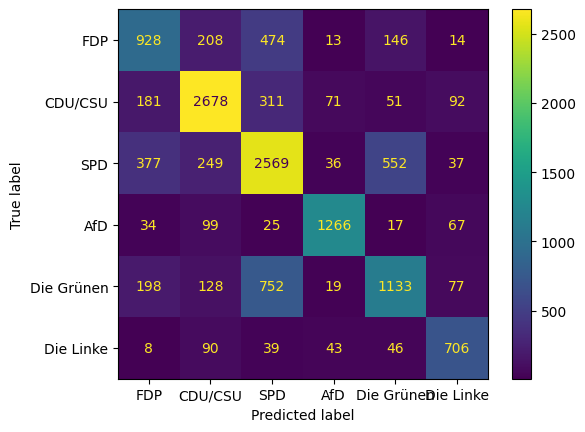

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = fraktionen)

disp.plot()
plt.show()

Das Modell speichern:
(es werden nur die Gewichte gespeichert, das Modell muss zum Laden wieder initialisiert werden)

In [ ]:

torch.save(model.state_dict(), "/content/drive/MyDrive/Modelle/GBERTmodel.pth")

Das Modell wieder laden:

In [ ]:
import torch

model.load_state_dict(torch.load("/content/drive/MyDrive/Modelle/GBERTmodel.pth"))

<ipython-input-25-d34866f8b0d5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/Modelle/GBERTmodel.pth"))


<All keys matched successfully>

Und hier das ganze nochmal **mit Accelerator**

dafür braucht man aber mehrere GPU's TPU's, ist etwas fortgeschritten

... den Teil mit torch und der GPU braucht man dafür nicht!

An dieser Stelle sollte vlt nochmal die Tokenisierung mit Padding und max_length = 512 oder so etwas angestrebt werden!

In [ ]:
from accelerate import Accelerator

In [ ]:
from tqdm.auto import tqdm
from accelerate import Accelerator

accelerator = Accelerator()

train_dataloader, eval_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
  for batch in train_dataloader:
    #compute model-outputs
    outputs = model(**batch)
    #compute loss
    loss = outputs.loss
    accelerator.backward(loss)

    #make a training step
    optimizer.step()
    #update learning rate
    lr_scheduler.step()
    #zero the gradients
    optimizer.zero_grad()
    progress_bar.update(1)

Und hier accelerated evaluation

In [ ]:
from evaluate import load

metric = load("glue", "mrpc")
model.eval()

eval_dataloader = accelerator.prepare(eval_dataloader)
for batch in eval_dataloader:
  with torch.nograd():
    outputs = model(**batch)

  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)
  metric.add_batch(
      predictions = accelerator.gather(predictions), references = accelerator.gather(batch["labels"])
  )

metric.compute()